# Classificador de sentenças utilizando GloVe embeddings bag - Experimento

Este componente é um classificador sentenças multiclasse baseado nos pacotes de Embeddings GloVe disponiblizado pela [Stanford](https://nlp.stanford.edu/projects/glove/) para a lngua inglesa e pelo [NILC-São Carlos](http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc) para a língua portuguesa.

Este notebook apresenta:
- como usar o [SDK](https://platiagro.github.io/sdk/) para carregar datasets, salvar modelos e outros artefatos.
- como declarar parâmetros e usá-los para criar componentes reutilizáveis.

## Declare parâmetros e hiperparâmetros para o modelo
Os componentes podem declarar (e usar) estes parâmetros como padrão:
- dataset
- target

Use estes parâmetros para carregar/salvar conjutos de dados, modelos, métricas e figuras com a ajuda do [SDK da PlatIAgro](https://platiagro.github.io/sdk/). <br>
É possível também declarar parâmetros personalizados para serem definidos ao executar um experimento. 

Selecione os hiperparâmetros e seus respectivos valores para serem usados ao treinar o modelo:
- language

Estes parâmetros são alguns dos oferecidos pela classe do modelo, você também pode utilizar outros existentes. <br>
Dê uma olhada nos [parâmetros do modelo](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn-impute-simpleimputer) para mais informações.

In [1]:
# Parametros Genéricos
dataset = "imdb.csv" #@param {type:"string"}
text_column = "text" #@param {type:"feature",label:"Coluna de entrada",description:"Seu modelo utilizará para treinamento a coluna selecionada."}
target_column = "label" #@param {type:"feature", label:"Coluna alvo", description:"Seu modelo será treinado para prever os valores do alvo."}
glove_weights_file_name = "glove_s300_ingles.txt" #@param {type:"string", label:"Arquivo de pesos", description:"É possível passar o arquivo comprimido em (.zip) ou não no formato (.txt) no experimento. Caso não seja possível o componente tentará descomprimir o arquivo antes."}
language = "ingles" #@param ["portugues", "ingles"] {type:"string", label:"Idioma", description:"Idioma em que os stopwords pertencem. Deve ser o mesmo utilizado no dataset."}
plots_ignore = [""] #@param ["Dados de Treino", "Matriz de Confusão", "Métricas Comuns", "Curva ROC", "Tabelas de Dados","Performance Batch Treinamento","Performance Época Treinamento","Performance Batch Validação","Performance Época Validação"] {type:"string",multiple:true,label:"Gráficos a serem ignorados", description: "Diversos gráficos são gerados ao executar o treinamento e validação do modelo, selecione quais não devem ser gerados."}

# Hyperparâametros
train_batch_size = 10 #@param {type:"integer",label:"Tamanho do batch de treinamento",description:"O tamanho do batch de treinamento interfere na quantidade de dados que irá atualizar o modelo por backpropagation. Se muito grande pode gerar esoturos memória."}
eval_batch_size = 2 #@param {type:"integer",label:"Tamanho do batch de inferência",description:"O tamanho do batch de inferência diz a quantidade de resultados que podem ser calculados em uma operação. Se muito grande pode gerar esoturos memória."}
max_epochs = 200 #@param {type:"integer",label:"Número de épocas",description:"Quantidade de vezes que todos os dados serão vistos durante o treinamento. É considerado também para a recuperação de pesos pré treinados"}
accumulate_grad_batches = 8 #@param {type:"integer",label:"Acúmulo de batchs",description:"Estratégia para atualizar os pesos não em todos os batchs mas a cada uma certa quantidade sem passar muitos batchs por vez durante o treinamento."}
learning_rate = 0.12 #@param {type:"number",label:"Taxa de aprendizado",description:"Velocidade em que o algorítimo irá aprender."}
seed = 42 #@param {type:"integer",label:"Semente de aleatoriedade",description:"Semente para replicação dos resultados."}
hidden_dims = [200,100,50] #@param [1000,500,300,200,100,50,20,10] {type:"integer",multiple:true,label:"Dimensão das camada escondidas",description:"Dimensão da camadas escondidas da rede neural de classifcação."}
hiddem_activation_function = "relu" #@param ["relu","tanh"] {type:"string",label:"Função de ativação",description:"Função de ativação utilizada nas camadas ocultas da MLP"}
glove_dim = 300 #@param [50,100,200,300,600,1000] {type:"integer",label:"Dimensão dos vetores Glove",description:"Dimensão dos vetores Glove pré treinados. Opções do inglês:50,100,200,300. Opções do português:50,100,300,600,1000"}

# Parametros Lightning
use_gpu = True #@param {type:"boolean",label:"Utilizar GPUs?",description:"Em caso positivo irá utilzar a GPU senão utilizará as CPUs. Se não houver GPU disponível irá utilziar CPUs"}
check_val_every_n_epoch = 5 #@param {type:"integer",label:"Checagem do conjunto de validação",description:"Irá interferir nos dataframes e gráficos de performance do conjunto de validação. Quanto menor, mais detalhes, porém mais lento (múltiplas inferências)"}
profiler=True #@param {type:"boolean",label:"Mostrar informações do modelo",description:"Informações automáticas disponibilizadas pelo Pytorch Lightning."}
progress_bar_refresh_rate=5 #@param {type:"integer",label:"Taxa de atualização da barra de progresso do modelo", description:"Serve para acompanhar o a loss do modelo enquanto treina. Interssante ser bastante alto no momentoda implantação, pois não é necessário."}

## Verificações dos parametros

In [2]:
if language== "ingles":
    if glove_dim not in [50,100,200,300]:
        raise Exception("Os Embeddings Glove em inglês existem apenas nas dimensões 50, 100, 200, 300")

elif language == "portugues":
    if glove_dim not in [50,100,300,600,1000]:
        raise Exception("Os Embeddings Glove em inglês existem apenas nas dimensões 50, 100, 300, 600, 1000")

In [3]:
if not hidden_dims:
    raise Exception("A rede deve possuir ao menos uma camada escondida")

## Configurações Gerais



Definindo diretóritório atual

In [4]:
import os
workdir = os.getcwd()

Definindo GPU como padrão e verificando status de hardware

In [5]:
import os
from multiprocessing import cpu_count
import torch

if use_gpu:
    dev = "cuda:0" if torch.cuda.is_available() else "cpu"
    device = torch.device(dev)
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")
    num_gpus = 1
else:
    device = torch.device("cpu")
    print(f"number of CPU cores: {cpu_count()}")
    num_gpus = 0

GPU: Tesla T4, number of CPU cores: 8


Impedir excesso de logs

In [6]:
import logging

logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [7]:
import pandas as pd

df = pd.read_csv(dataset)

## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [8]:
import numpy as np
from platiagro import stat_dataset

columns = df.columns.to_numpy()
target_index = np.argwhere(columns == target_column)
columns = np.delete(columns, target_index)

## Remoção de linhas com valores faltantes no atributo alvo

Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.

In [9]:
from sklearn.preprocessing import LabelEncoder

df.dropna(subset=[target_column], inplace=True)
y = df[target_column].to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## Filtragem das features 

Seleciona a coluna que contém o texto text_column.

In [10]:
columns_index = (np.where(np.isin(columns, text_column)))[0]
columns_index.sort()
columns_to_filter = columns[columns_index]
# keep the features selected
df_model = df[columns_to_filter]
X = df_model.to_numpy()

## Divisão do datset em subconjuntos de treino e teste

Subconjunto de Treino: amostras de dados usado para treinar o modelo (``fit``). <br>
Subconjunto de Teste: a amostra de dados usada para fornecer uma avaliação imparcial de um modelo adequado ao conjunto de dados de treinamento.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=0.8, random_state=seed, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)

## Download dos Embeddings e criação das matrizes do GloVe

In [12]:
if not os.path.exists(os.path.join(workdir,'glove_embeddings.py')):
    !wget https://raw.githubusercontent.com/platiagro/tasks/main/tasks/nlp-glove-embeddings-sentence-classification/glove_embeddings.py

Download dos Embeddings

In [13]:
from glove_embeddings import GloveEmbeddings
glove_embeddings = GloveEmbeddings(glove_dim=glove_dim,glove_weights_file_name=glove_weights_file_name,device=device)
X_train_glove_ids, X_train_glove_words = glove_embeddings.build_glove_matrix(X_train)
X_valid_glove_ids, X_valid_glove_words = glove_embeddings.build_glove_matrix(X_valid)
X_test_glove_ids, X_test_glove_words = glove_embeddings.build_glove_matrix(X_test)

## Recuperação do Modelo Pytorch Lightning

In [14]:
if not os.path.exists(os.path.join(workdir,'dataset.py')):
    !wget https://raw.githubusercontent.com/platiagro/tasks/main/tasks/nlp-glove-embeddings-sentence-classification/dataset.py

In [15]:
if not os.path.exists(os.path.join(workdir,'model_lightning.py')):
    !wget https://raw.githubusercontent.com/platiagro/tasks/main/tasks/nlp-glove-embeddings-sentence-classification/model_lightning.py

Parâmetros do Modelo

In [16]:
import pytorch_lightning as pl
from dataset import MyDataset
from model_lightning import GloveFinetuner

all_data = {
    "X_train_glove_ids":X_train_glove_ids,
    "X_train_glove_words":X_train_glove_words,
    "y_train":y_train,
    "X_valid_glove_ids":X_valid_glove_ids,
    "X_valid_glove_words":X_valid_glove_words,
    "y_valid":y_valid,
    "X_test_glove_ids":X_test_glove_ids,
    "X_test_glove_words":X_test_glove_words,
    "y_test":y_test,
}

hyperparams = {
    "learning_rate": learning_rate,
    "train_batch_size":train_batch_size,
    "eval_batch_size": eval_batch_size,
    "max_epochs": max_epochs,
    "accumulate_grad_batches": accumulate_grad_batches,
    "seed": seed,
    "hiddem_activation_function":hiddem_activation_function,
    "hidden_dims":hidden_dims,
}
model_parameters = {
    "criterion": torch.nn.CrossEntropyLoss(),
    "label_encoder": label_encoder,
    "glove_infos":glove_embeddings.glove_infos
}

dataset_infos = {"all_data": all_data, "CustomDataset": MyDataset}
extra_infos = {"overfit": False, "sampler": False, "device":device}

In [17]:
model = GloveFinetuner(
    hyperparams=hyperparams,
    model_parameters=model_parameters,
    dataset_infos=dataset_infos,
    extra_infos=extra_infos,
)
sum(
    [torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]
)  # trainable parameters

Global seed set to 42


tensor(85452)

In [18]:
trainer = pl.Trainer(
    gpus=num_gpus, checkpoint_callback=False, fast_dev_run=True  # Disable checkpoint saving.
)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_funtion  | CrossEntropyLoss | 0     
1 | predict_proba | Softmax          | 0     
2 | embedding_bag | EmbeddingBag     | 120 M 
3 | net           | Sequential       | 85.5 K
---------------------------------------------------
85.5 K    Trainable params
120 M     Non-trainable params
120 M     Total params
480.342   Total estimated model params size (MB)


1

In [19]:
trainer.test(model)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_acc': 1.0, 'test_acc_batch': 1.0, 'test_acc_batch_epoch': 1.0}
--------------------------------------------------------------------------------


[{'test_acc_batch_epoch': 1.0, 'test_acc_batch': 1.0, 'avg_test_acc': 1.0}]

Recuperando ou treinando o modelo

In [20]:
import os
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_path = f"/tmp/data/epoch={max_epochs-1}.ckpt"
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir, save_top_k=-1, monitor="avg_valid_acc", filename='{epoch}'
)  # Keeps all checkpoints.

trainer = pl.Trainer(
    gpus=num_gpus,
    max_epochs=max_epochs,
    check_val_every_n_epoch=check_val_every_n_epoch,
    profiler=profiler,
    checkpoint_callback=checkpoint_callback,
    progress_bar_refresh_rate=progress_bar_refresh_rate,
)

model = GloveFinetuner(
    hyperparams=hyperparams,
    model_parameters=model_parameters,
    dataset_infos=dataset_infos,
    extra_infos=extra_infos,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Global seed set to 42

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_funtion  | CrossEntropyLoss | 0     
1 | predict_proba | Softmax          | 0     
2 | embedding_bag | EmbeddingBag     | 120 M 
3 | net           | Sequential       | 85.5 K
---------------------------------------------------
85.5 K    Trainable params
120 M     Non-trainable params
120 M     Total params
480.342   Total estimated model params size (MB)




Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  19.9           	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.7569         	|10             	|  17.569         	|  88.29          	|
get_train_batch                    	|  0.0086358      	|800            	|  6.9086         	|  34.717         	|
run_training_batch                 	|  0.0043437      	|800            	|  3.475          	|  17.463         	|
on_validation_end                  	|  1.1166         	|3              	|  3.3497         	|  16.833         	|
optimizer_step_and_closure_0       	|  0.

1

In [21]:
trainer.test(model)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_acc': 0.53,
 'test_acc_batch': 1.0,
 'test_acc_batch_epoch': 0.5161252021789551}
--------------------------------------------------------------------------------


[{'test_acc_batch_epoch': 0.5161252021789551,
  'test_acc_batch': 1.0,
  'avg_test_acc': 0.53}]

## Visualização das métricas do modelo

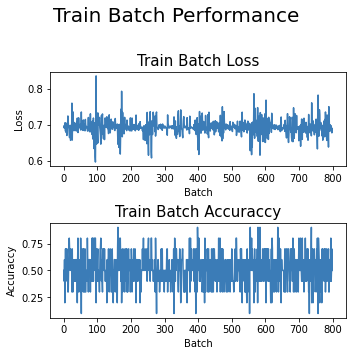

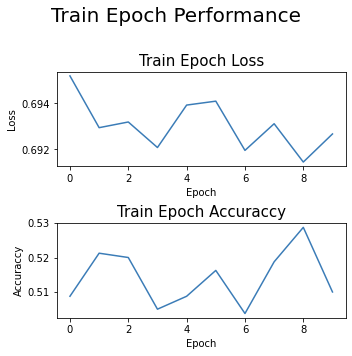

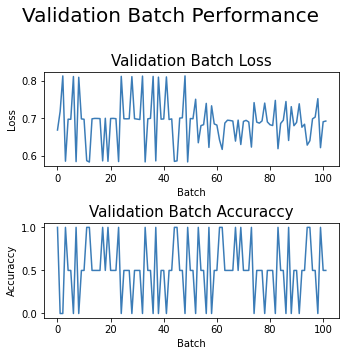

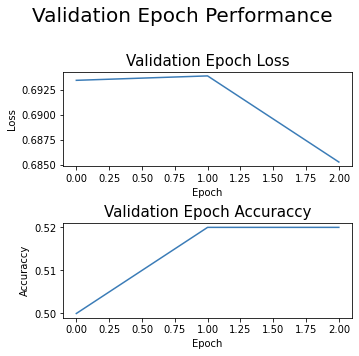

In [22]:
from platiagro.plotting import plot_line_subgraphs_alongisde


if "Performance Batch Treinamento" not in plots_ignore: 
    n_batchs_train = model.df_performance_train_batch["train_batch_loss"].to_numpy().shape[0]
    plot_line_subgraphs_alongisde(x_list = [np.arange(n_batchs_train),np.arange(n_batchs_train)],
                                  y_list = [model.df_performance_train_batch["train_batch_loss"].to_numpy(),model.df_performance_train_batch["train_batch_acc"].to_numpy()],
                                      x_axe_names = ["Batch"], 
                                      y_axe_names = ["Loss", "Accuraccy"],
                                      col_wrap = 1,
                                      suptitle = "Train Batch Performance",
                                      subtitles = ["Train Batch Loss", "Train Batch Accuraccy"])

if "Performance Época Treinamento" not in plots_ignore:
    plot_line_subgraphs_alongisde(x_list = [np.arange(max_epochs),np.arange(max_epochs)],
                              y_list = [model.df_performance_train_epoch["train_epoch_loss"].to_numpy(),model.df_performance_train_epoch["train_epoch_acc"].to_numpy()],
                                  x_axe_names = ["Epoch"], 
                                  y_axe_names = ["Loss", "Accuraccy"],
                                  col_wrap = 1,
                                  suptitle = "Train Epoch Performance",
                                  subtitles = ["Train Epoch Loss", "Train Epoch Accuraccy"])

if "Performance Batch Validação" not in plots_ignore:
    n_batchs_valid = model.df_performance_valid_batch["valid_batch_loss"].to_numpy().shape[0]
    plot_line_subgraphs_alongisde(x_list = [np.arange(n_batchs_valid),np.arange(n_batchs_valid)],
                              y_list = [model.df_performance_valid_batch["valid_batch_loss"].to_numpy(),model.df_performance_valid_batch["valid_batch_acc"].to_numpy()],
                                  x_axe_names = ["Batch"], 
                                  y_axe_names = ["Loss", "Accuraccy"],
                                  col_wrap = 1,
                                  suptitle = "Validation Batch Performance",
                                  subtitles = ["Validation Batch Loss", "Validation Batch Accuraccy"])

if "Performance Época Validação" not in plots_ignore:
    n_epochs_valid = model.df_performance_valid_epoch["valid_epoch_acc"].to_numpy().shape[0]
    plot_line_subgraphs_alongisde(x_list = [np.arange(n_epochs_valid),np.arange(n_epochs_valid)],
                              y_list = [model.df_performance_valid_epoch["valid_epoch_loss"].to_numpy(),model.df_performance_valid_epoch["valid_epoch_acc"].to_numpy()],
                                  x_axe_names = ["Epoch"], 
                                  y_axe_names = ["Loss", "Accuraccy"],
                                  col_wrap = 1,
                                  suptitle = "Validation Epoch Performance",
                                  subtitles = ["Validation Epoch Loss", "Validation Epoch Accuraccy"])

## Visualização do desempenho
A [**Matriz de Confusão**](https://en.wikipedia.org/wiki/Confusion_matrix) (Confusion Matrix) é uma tabela que nos permite a visualização do desempenho de um algoritmo de classificação. <br>
É extremamente útil para mensurar [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), [Recall, Precision, and F-measure](https://en.wikipedia.org/wiki/Precision_and_recall).

In [23]:
from sklearn.metrics import confusion_matrix

# uses the model to make predictions on the Test Dataset
y_pred = list(model.df_test["PREDICTED_CODE"])
y_prob = np.squeeze(np.array([list(elem)for elem in zip(list(model.df_test[col_name]) for col_name in model.df_test.columns[4:])])).T

# computes confusion matrix
labels = np.unique(y)
data = confusion_matrix(y_test, y_pred, labels=labels)

# puts matrix in pandas.DataFrame for better format
labels_dec = label_encoder.inverse_transform(labels)
confusion_matrix = pd.DataFrame(data, columns=labels_dec, index=labels_dec)

## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [24]:
# from platiagro import save_metrics

# save_metrics(confusion_matrix=confusion_matrix)

import mlflow

with mlflow.start_run():
    mlflow.sklearn.autolog()
    mlflow.log_param("confusion_matrix", confusion_matrix)

## Visualiza resultados
A avaliação do desempenho do modelo pode ser feita por meio da análise da Curva ROC (ROC). Esse gráfico permite avaliar a performance de um classificador binário para diferentes pontos de cortes. A métrica AUC (Area under curve) também é calculada e indicada na legenda do gráfico. Se a variável resposta tiver mais de duas categorias, o cálculo da curva ROC e AUC é feito utilizando o algoritmo one-vs-rest, ou seja, calcula-se a curva ROC e AUC de cada classe em relação ao restante.

In [25]:
import matplotlib.pyplot as plt

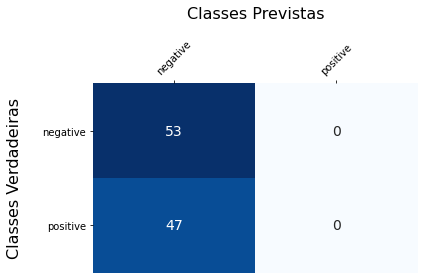

In [26]:
from platiagro.plotting import plot_matrix

if "Matriz de Confusão" not in plots_ignore:
    
    plot_matrix(confusion_matrix)
    plt.show()

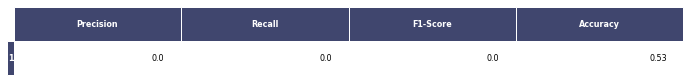

In [27]:
from platiagro.plotting import plot_common_metrics

if "Métricas Comuns" not in plots_ignore:
    
    plot_common_metrics(y_test, y_pred, labels, labels_dec)
    plt.show()

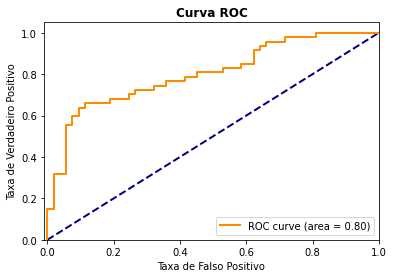

In [28]:
from platiagro.plotting import plot_roc_curve

if "Curva ROC" not in plots_ignore:
    
    plot_roc_curve(y_test, y_prob, labels_dec)
    plt.show()

Verificando resultados em do modelo no conjunto de teste

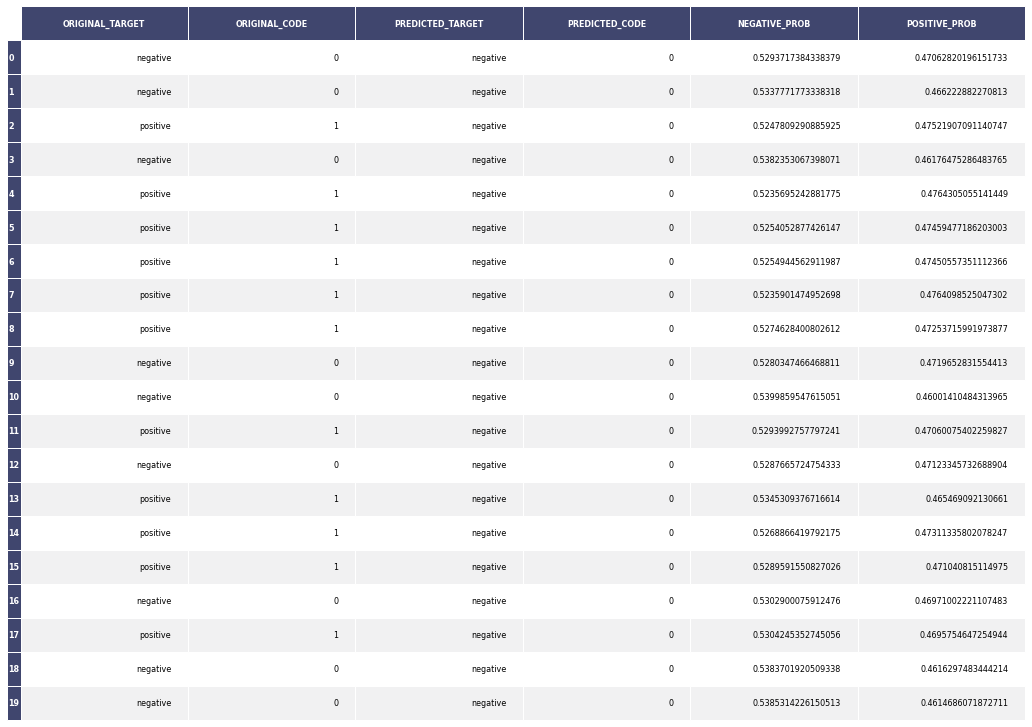

In [29]:
from platiagro.plotting import plot_data_table

if "Tabelas de Dados" not in plots_ignore:

    ax = plot_data_table(model.df_test)
    plt.show()

## Salva modelo e outros artefatos

In [30]:
import pickle

dataset_infos = {"all_data": None}


model_parameters = {
    "criterion": torch.nn.CrossEntropyLoss(),
    "label_encoder": label_encoder,
}

extra_infos = {"overfit": False, "sampler": False}


deployment_infos = {"columns": columns,
                    "X_test": X_test,
                    "glove_dim":glove_dim,
                    "glove_weights_file_name":glove_weights_file_name,
                    "checkpoint_path":checkpoint_path,
                    "X_test":X_test
                   }

lightning_configs = {
    "num_gpus":num_gpus,
    "check_val_every_n_epoch":check_val_every_n_epoch,
    "profiler":profiler,
    "progress_bar_refresh_rate":progress_bar_refresh_rate,
}
artifacts = {
    "hyperparams": hyperparams,
    "model_parameters": model_parameters,
    "dataset_infos": dataset_infos,
    "extra_infos": extra_infos,
    "deployment_infos": deployment_infos,
    "lightning_configs":lightning_configs,
}

file_name = "artifacts.p"
pickle.dump(artifacts, open(f"/tmp/data/{file_name}", "wb"))